In [181]:
# Building a basic selector ML algorithm for picking simulation strategy with inferQ data

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [188]:
PRIMARY_KEY = "RowKey"
qiskit_sim = pd.read_csv("data_clean_sim_auto_worked_qiskit.csv")
inferq_features = pd.read_csv("data_clean_features.csv")
df_dropped = pd.merge(qiskit_sim, inferq_features, on=PRIMARY_KEY, how="inner")

cols = df_dropped.columns.tolist()
# let us remove some columns that we do not need
DROP_COLS = [
    "blob_url",
    "RowKey",
    "PartitionKey",
    "name",
    "serialization_method",
    "qpy_serialization_success",
    "gate_counts",
    "automatic_method"
]

ALL_METHODS = [
    "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]

DROP_FAILED_SIM = [
    f"{m}_{suffix}"
    for m in ALL_METHODS
    for suffix in (
        "transpiled_size",
        "transpiled_depth",
        "memory_usage",
        "execution_time",
        "gate_counts",
    )
]

FEATURES = [c for c in df_dropped.drop(columns=DROP_COLS).columns.tolist() if c not in DROP_FAILED_SIM]

METHODS = [
    "statevector_saved",
    # "statevector",
    # "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    # "unitary",
    # "automatic"
]

print(FEATURES)
print(len(df_dropped))

['average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'num_qubits', 'pauli_gate_count', 'radius', 'statevector_saved_entropy', 'statevector_saved_sparsity', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']
45376


In [189]:
def best_method(row):
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t
    return min(costs, key=costs.get) if costs else np.nan

df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)
df_clean = df_dropped.dropna(subset=["best_method"])
print(len(df_clean))

45376


# Feature Analysis

In [190]:
# from utils import PlotHistPercentBest

# PlotHistPercentBest(METHODS, FEATURES, df_clean)

In [191]:
# from utils import PlotHeatMapAvg
# PlotHeatMapAvg(METHODS, FEATURES, df_clean)

# Best Method

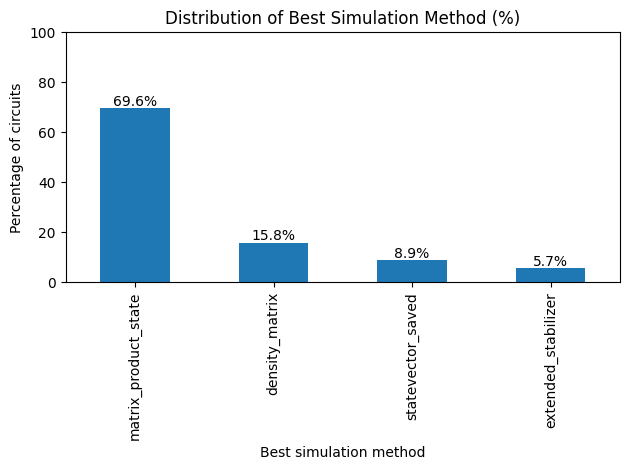

In [236]:
import matplotlib.pyplot as plt

percentages = 100 * df_clean["best_method"].value_counts() / len(df_clean)

ax = percentages.plot(kind="bar")
plt.xlabel("Best simulation method")
plt.ylabel("Percentage of circuits")
plt.title("Distribution of Best Simulation Method (%)")
plt.ylim(0, 100)

# Add percentage labels on top of bars
for i, pct in enumerate(percentages):
    ax.text(i, pct + 1, f"{pct:.1f}%", ha='center')

plt.tight_layout()
plt.show()



In [193]:
total = len(df_clean)
print(df_clean["best_method"].value_counts())
print(len(df_clean))
print(df_clean["best_method"].value_counts()/total)

best_method
matrix_product_state    31570
density_matrix           7183
statevector_saved        4020
extended_stabilizer      2603
Name: count, dtype: int64
45376
best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: count, dtype: float64


In [240]:
import pandas as pd
import numpy as np

rank_counts = pd.DataFrame(0, index=METHODS, columns=range(1, len(METHODS)+1))

for _, row in df_clean.iterrows():
    # Build a dict of method: cost for this row
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t

    if not costs:
        continue  # skip rows with no valid methods

    # Rank methods by cost (ascending = smaller is better)
    ranked_methods = sorted(costs, key=costs.get)  # best -> worst

    # Only tally ranks for methods that exist
    for m in ranked_methods:
        actual_rank = ranked_methods.index(m) + 1
        rank_counts.loc[m, actual_rank] += 1

print(rank_counts)


                          1      2      3     4
statevector_saved      4020   1630  32959  6767
density_matrix         7183   6410   1884   241
matrix_product_state  31570  10898   2505   403
extended_stabilizer    2603  26438   8028  8307


In [194]:
X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean["best_method"]

# PCA 

In [195]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # Standardize features
# X_PCA = StandardScaler().fit_transform(X)

# print(len(FEATURES))

# # Fit PCA to inspect explained variance
# pca = PCA()
# pca.fit(X_PCA)

# # Cumulative explained variance
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# # Plot cumulative explained variance
# plt.figure()
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Cumulative Explained Variance")
# plt.grid(True)
# plt.show()

# # Number of components needed for 95% variance
# n_components = np.argmax(cumulative_variance >= 0.89) + 1
# print(f"Number of components needed for 95% variance: {n_components}")

# # Apply PCA with 15 components and overwrite X
# pca_n = PCA(n_components)
# X = pd.DataFrame(
#     pca_n.fit_transform(X_PCA),
#     columns=[f"PC{i+1}" for i in range(n_components)],
#     index=X.index
# )

# print(X.shape)


# Training Models

In [253]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

TARGET = "best_method"
RANDOM_STATE = 42

X = df_clean[FEATURES]
y = df_clean[TARGET]

y_original = df_clean[TARGET]


X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
y.value_counts(normalize=True)


best_method
matrix_product_state    0.695742
density_matrix          0.158300
statevector_saved       0.088593
extended_stabilizer     0.057365
Name: proportion, dtype: float64

In [254]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
def PlotConfusionReport(y_test, y_pred, method):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=METHODS,
        display_labels=METHODS,
        ax=axes[0],
        xticks_rotation=45,
        normalize=None
    )
    axes[0].set_title("Confusion Matrix (Counts)")
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=METHODS,
        display_labels=METHODS,
        ax=axes[1],
        xticks_rotation=45,
        normalize="true"
    )
    axes[1].set_title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()

    # Compute normalized confusion matrix
    cm_norm = confusion_matrix(y_test, y_pred, labels=METHODS, normalize='true')
    
    # Count how many classes have diagonal > 0.7
    correct_diag = np.diag(cm_norm)
    above_70 = np.sum(correct_diag > 0.7)
    
    print(f"Number of classes with >70% correct predictions: {above_70} out of {len(METHODS)}")
    for idx, val in enumerate(correct_diag):
        print(f"{METHODS[idx]}: {val:.2f}")

# Naive Bayes Gaussian

                      precision    recall  f1-score   support

      density_matrix       0.42      0.40      0.41      1437
 extended_stabilizer       0.12      0.87      0.21       521
matrix_product_state       0.94      0.42      0.58      6314
   statevector_saved       0.52      0.72      0.60       804

            accuracy                           0.47      9076
           macro avg       0.50      0.60      0.45      9076
        weighted avg       0.77      0.47      0.53      9076



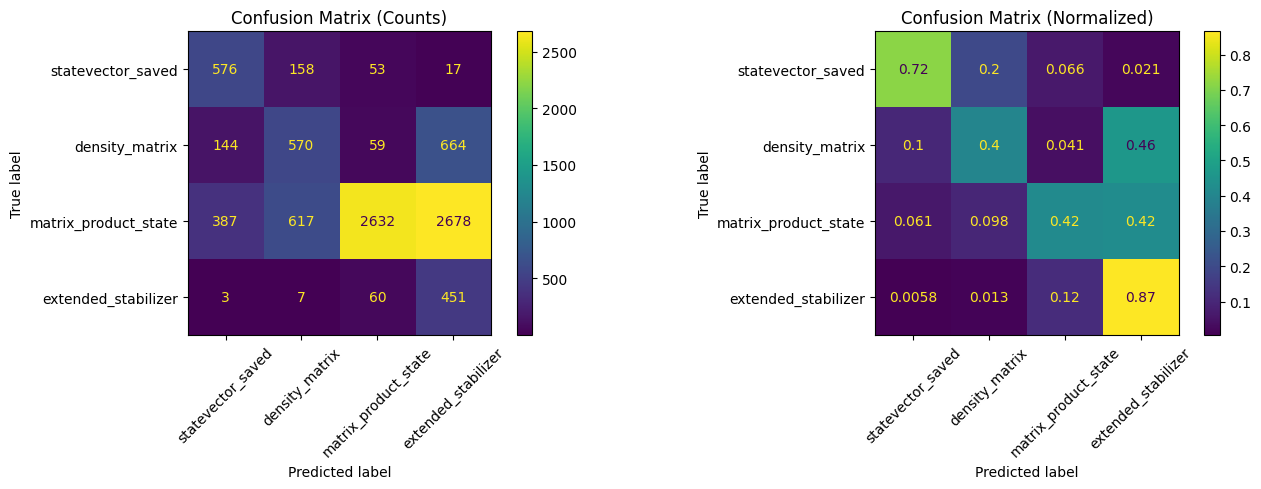

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.72
density_matrix: 0.40
matrix_product_state: 0.42
extended_stabilizer: 0.87


In [255]:
from sklearn.naive_bayes import GaussianNB

modelNaiveBayes = GaussianNB()
modelNaiveBayes.fit(X_train, y_train)
y_predNaiveBayes = modelNaiveBayes.predict(X_test)

print(classification_report(y_test, y_predNaiveBayes))
PlotConfusionReport(y_test, y_predNaiveBayes, "Naive Bayes")

# Logisitic Regression

                      precision    recall  f1-score   support

      density_matrix       0.48      0.70      0.57      1437
 extended_stabilizer       0.20      0.79      0.32       521
matrix_product_state       0.94      0.56      0.70      6314
   statevector_saved       0.56      0.82      0.66       804

            accuracy                           0.62      9076
           macro avg       0.54      0.72      0.56      9076
        weighted avg       0.79      0.62      0.66      9076



c:\Users\aadik\InferQ\analysis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


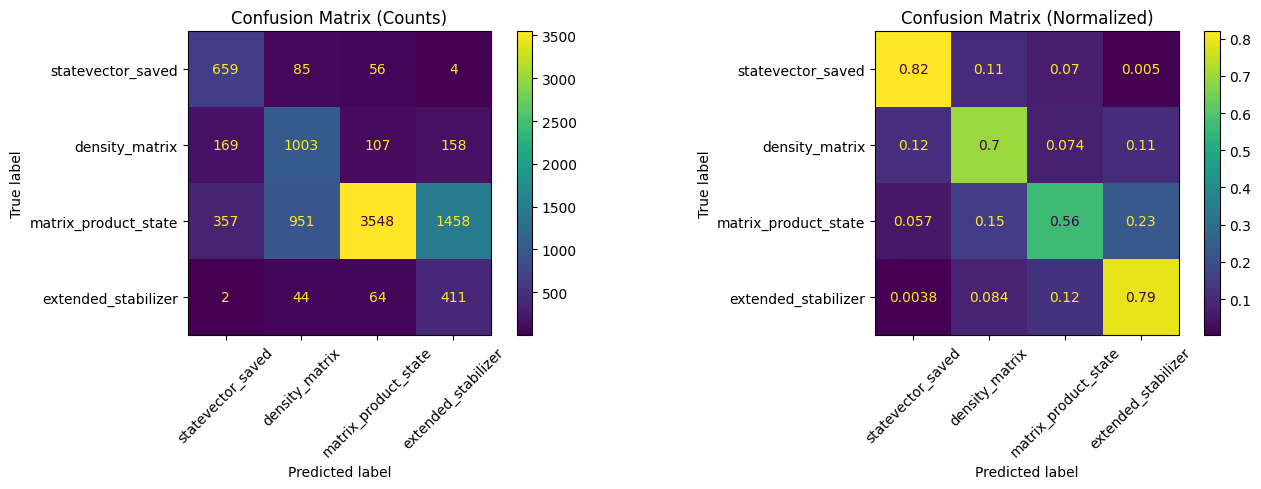

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.82
density_matrix: 0.70
matrix_product_state: 0.56
extended_stabilizer: 0.79


In [256]:
from sklearn.linear_model import LogisticRegression

modelLogisticRegression = LogisticRegression(
    random_state=42,
    class_weight="balanced",
)

modelLogisticRegression.fit(X_train, y_train)
y_predLogisticRegression = modelLogisticRegression.predict(X_test)

print(classification_report(y_test, y_predLogisticRegression))

PlotConfusionReport(y_test, y_predLogisticRegression, "Logistic Regression")


# KNN

                      precision    recall  f1-score   support

      density_matrix       0.49      0.49      0.49      1437
 extended_stabilizer       0.54      0.45      0.49       521
matrix_product_state       0.83      0.85      0.84      6314
   statevector_saved       0.77      0.71      0.74       804

            accuracy                           0.76      9076
           macro avg       0.66      0.63      0.64      9076
        weighted avg       0.75      0.76      0.76      9076



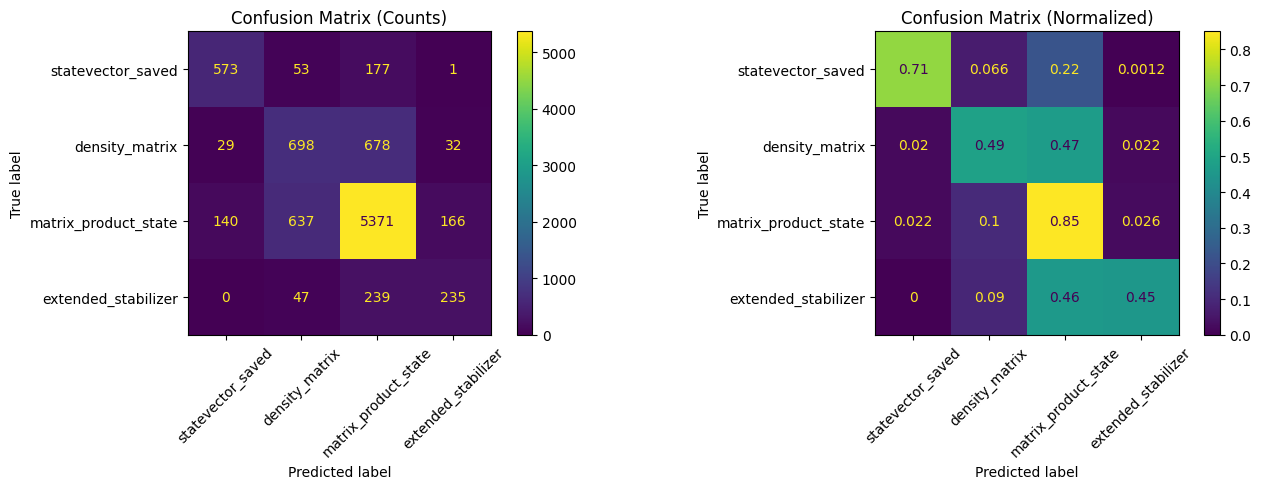

Number of classes with >70% correct predictions: 2 out of 4
statevector_saved: 0.71
density_matrix: 0.49
matrix_product_state: 0.85
extended_stabilizer: 0.45


In [257]:
from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier(
    n_neighbors=5
)

modelKNN.fit(X_train, y_train)
y_predKNN = modelKNN.predict(X_test)

print(classification_report(y_test, y_predKNN))
PlotConfusionReport(y_test, y_predKNN, "K-Nearest Neighbors")

# Decision Tree

                      precision    recall  f1-score   support

      density_matrix       0.49      0.88      0.63      1437
 extended_stabilizer       0.33      0.78      0.46       521
matrix_product_state       0.97      0.66      0.79      6314
   statevector_saved       0.70      0.87      0.78       804

            accuracy                           0.72      9076
           macro avg       0.62      0.80      0.67      9076
        weighted avg       0.83      0.72      0.74      9076



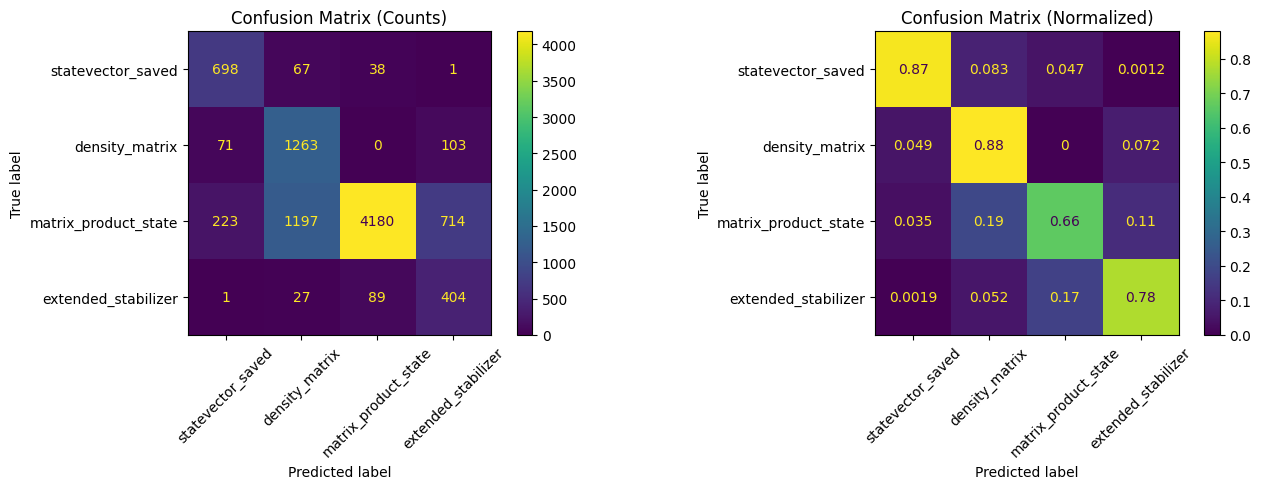

Number of classes with >70% correct predictions: 3 out of 4
statevector_saved: 0.87
density_matrix: 0.88
matrix_product_state: 0.66
extended_stabilizer: 0.78


In [258]:
from sklearn.tree import DecisionTreeClassifier

modelDecisionTree = DecisionTreeClassifier(
    max_depth=5,
    random_state=42,
    class_weight="balanced",
)

modelDecisionTree.fit(X_train, y_train)
y_predDecisionTree = modelDecisionTree.predict(X_test)

print(classification_report(y_test, y_predDecisionTree))
PlotConfusionReport(y_test, y_predDecisionTree, "Decision Tree")

# Random Forest 

                      precision    recall  f1-score   support

   statevector_saved       0.72      0.93      0.81       804
      density_matrix       0.50      0.89      0.64      1437
matrix_product_state       0.98      0.70      0.82      6314
 extended_stabilizer       0.41      0.76      0.54       521

            accuracy                           0.75      9076
           macro avg       0.65      0.82      0.70      9076
        weighted avg       0.85      0.75      0.77      9076



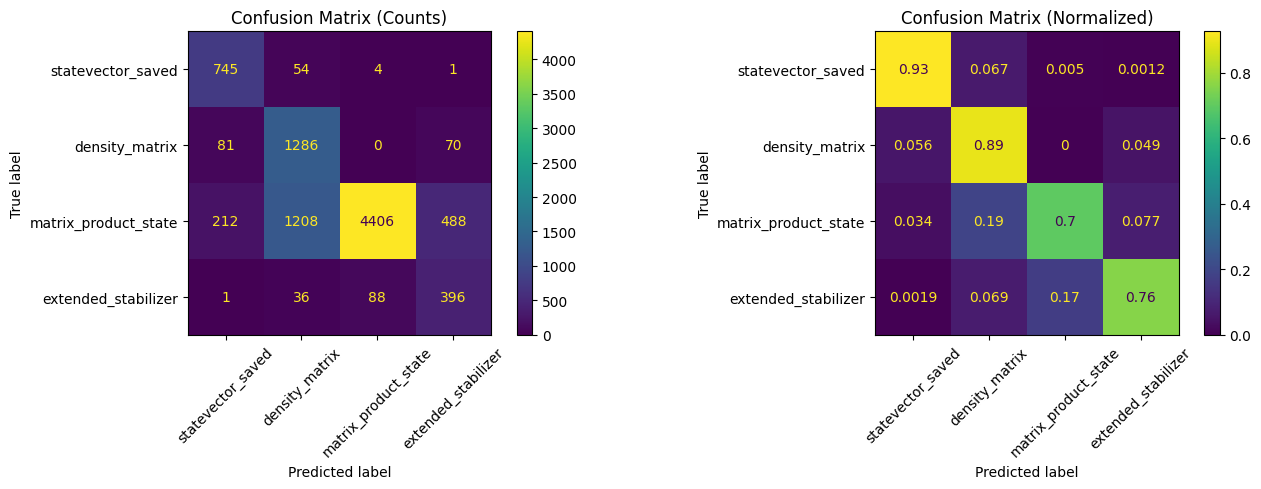

Number of classes with >70% correct predictions: 3 out of 4
statevector_saved: 0.93
density_matrix: 0.89
matrix_product_state: 0.70
extended_stabilizer: 0.76


In [259]:
from sklearn.ensemble import RandomForestClassifier
modelRandomForest = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=10,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

modelRandomForest.fit(X_train, y_train)
y_predRandomForest = modelRandomForest.predict(X_test)

print(classification_report(
    y_test, y_predRandomForest,
    labels=METHODS,
    target_names = METHODS
))

PlotConfusionReport(y_test, y_predRandomForest, "Random Forest")

# XG Boost

                      precision    recall  f1-score   support

      density_matrix       0.51      0.92      0.65      1437
 extended_stabilizer       0.41      0.81      0.54       521
matrix_product_state       0.98      0.71      0.83      6314
   statevector_saved       0.86      0.93      0.89       804

            accuracy                           0.77      9076
           macro avg       0.69      0.84      0.73      9076
        weighted avg       0.86      0.77      0.79      9076



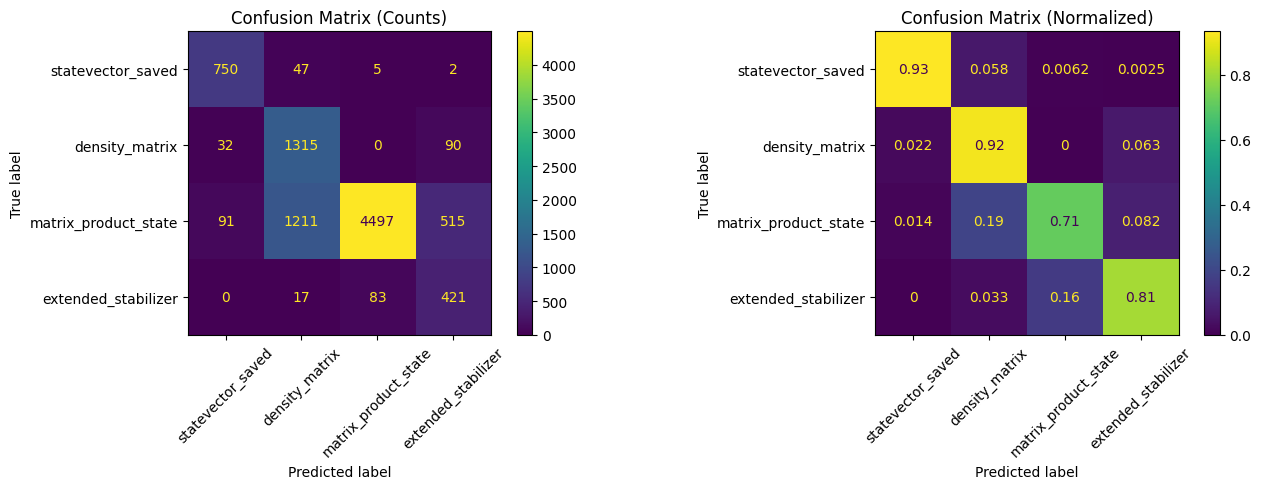

Number of classes with >70% correct predictions: 4 out of 4
statevector_saved: 0.93
density_matrix: 0.92
matrix_product_state: 0.71
extended_stabilizer: 0.81


In [260]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = len(le.classes_)

# model = XGBClassifier(
#     n_estimators=400,
#     max_depth=12,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     min_child_weight=10,
#     objective="multi:softmax",   # softmax since we want class labels
#     num_class=num_classes,
#     n_jobs=-1,
#     random_state=RANDOM_STATE,
#     eval_metric="mlogloss"
# )

# modelXGBoost = XGBClassifier(
#     n_estimators=100,            # fewer trees → faster, less overfitting
#     max_depth=4,                 # shallower → better generalization
#     learning_rate=0.1,           # slightly higher → faster learning
#     subsample=0.8,               # keep as is
#     colsample_bytree=0.8,        # keep as is
#     min_child_weight=1,          # smaller → allows splits for small classes
#     objective="multi:softmax",
#     num_class=num_classes,
#     n_jobs=-1,
#     random_state=RANDOM_STATE,
#     eval_metric="mlogloss",
#     scale_pos_weight=None         # can handle class imbalance manually if needed
# )

# ==================== Balanced XGBoost ====================

# Compute class weights based on frequency
class_counts = df_clean["best_method"].value_counts()
total = len(df_clean)
class_weights = {cls: total / count for cls, count in class_counts.items()}

# Map sample weights to training set (using numeric encoded labels)
weights = np.array([class_weights[le.inverse_transform([y])[0]] for y in y_train_enc])

modelXGBoost = XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    objective="multi:softmax",
    num_class=num_classes,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

# Fit using sample weights
modelXGBoost.fit(X_train, y_train_enc, sample_weight=weights)

# Predict numeric labels
y_pred_encXG = modelXGBoost.predict(X_test)

# Convert back to original class names
y_predXGBoost = le.inverse_transform(y_pred_encXG)

print(classification_report(y_test, y_predXGBoost))
PlotConfusionReport(y_test, y_predXGBoost, "XGBoost Classifier")


# SVC 

In [261]:
# print(X_train.isna().sum().sort_values(ascending=False))

                      precision    recall  f1-score   support

      density_matrix       0.49      0.71      0.58      1437
 extended_stabilizer       0.36      0.55      0.43       521
matrix_product_state       0.91      0.76      0.83      6314
   statevector_saved       0.71      0.84      0.76       804

            accuracy                           0.75      9076
           macro avg       0.62      0.71      0.65      9076
        weighted avg       0.80      0.75      0.76      9076



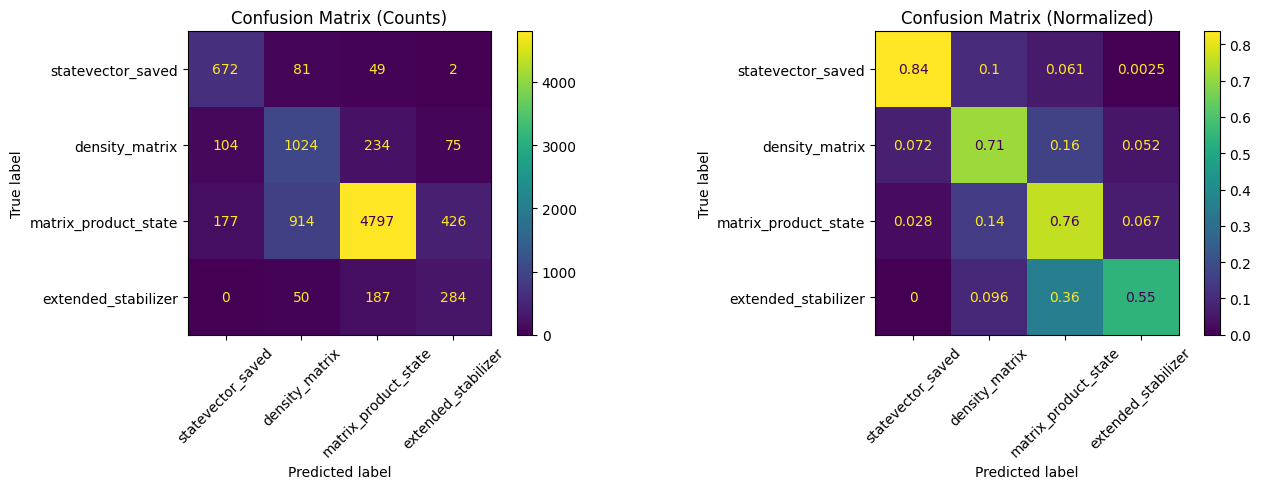

Number of classes with >70% correct predictions: 3 out of 4
statevector_saved: 0.84
density_matrix: 0.71
matrix_product_state: 0.76
extended_stabilizer: 0.55


In [262]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

modelSVC = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        C=10.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        max_iter=5000
    ))
])

modelSVC.fit(X_train, y_train_enc)

y_pred_encSVC = modelSVC.predict(X_test)
y_predSVC = le.inverse_transform(y_pred_encSVC)

print(classification_report(
    y_test,
    y_predSVC,
    labels=le.classes_,
    target_names=le.classes_
))


PlotConfusionReport(y_test, y_predSVC, "Linear SVM")


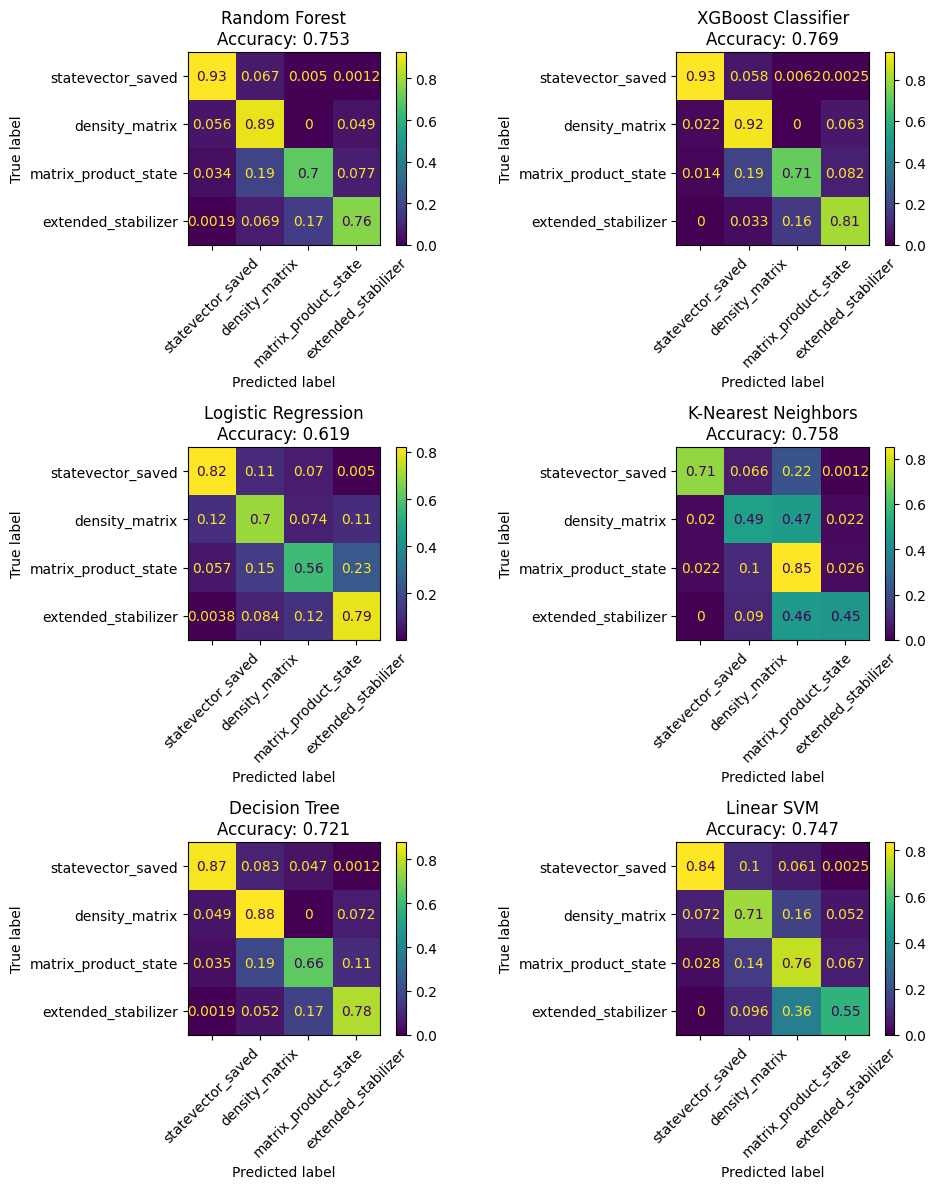

In [263]:
# Let us make subplots for all the models in one figure instead of seperate

model_to_y_pred = {
    "Random Forest": y_predRandomForest,
    "XGBoost Classifier": y_predXGBoost,
    # "Naive Bayes": y_predNaiveBayes,
    "Logistic Regression": y_predLogisticRegression,
    "K-Nearest Neighbors": y_predKNN,
    "Decision Tree": y_predDecisionTree,
    "Linear SVM": y_predSVC
}


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import math

def PlotConfusionReports(y_test, predictions_dict, methods):
    n_models = len(predictions_dict)
    n_rows = math.ceil(np.sqrt(n_models))
    n_cols = math.ceil(n_models / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (model_name, y_pred) in zip(axes, predictions_dict.items()):
        acc = accuracy_score(y_test, y_pred)

        ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            labels=methods,
            display_labels=methods,
            normalize="true",
            ax=ax,
            xticks_rotation=45
        )

        ax.set_title(f"{model_name}\nAccuracy: {acc:.3f}")

    for ax in axes[len(predictions_dict):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


PlotConfusionReports(y_test, model_to_y_pred, METHODS)


In [264]:
# Now let us compare against the accuracy of automatic
METHODS.append("automatic")

df_auto = df_dropped
print(len(df_auto))

df_auto["best_method"] = df_auto.apply(best_method, axis=1)
df_auto = df_auto.dropna(subset=["best_method"])

total = len(df_auto)

counts = df_auto["best_method"].value_counts()
percentages = counts / total * 100
summary_df = pd.DataFrame({
    "count": counts,
    "percentage": percentages
})
print(summary_df)
METHODS.remove("automatic")

45376
                      count  percentage
best_method                            
automatic             23466   51.714563
matrix_product_state  16080   35.437236
density_matrix         4422    9.745240
extended_stabilizer    1262    2.781206
statevector_saved       146    0.321756
